<a href="https://colab.research.google.com/github/celelunar/Stock-Prediction-LSTM-SeqSelfAttention/blob/main/Prediction%20Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Diva Nabila Henryka
<br>
NIM: 2501975620
<br>


---



You are an AI Engineer at a company working in the finance sector. Your team has been tasked with predicting the stock performance of Company "X". The
provided dataset, stored as "X.csv", contains several important details about each column. For this task, you will be focusing solely on the 'Date' and 'Close' columns.

### Preparation

#### Import libraries needed

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=88937d30b99d3102beb13b5e051a1cc1c756b9eb78c1ff2b9a064432d3c993c2
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_self_attention import SeqSelfAttention

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#### Accessing the dataset through Google Drive

I choose to store the dataset in my Google Drive to avoid the hassle of reuploading the dataset everytime the runtime gets disconnected.
<br>
In order to access the dataset, my Google Drive has to be mounted first, then read the dataset using:

```
pd.read_csv("/path to file/file.csv)
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Final/X.csv", usecols = ['Date', 'Close'])
data.head()

,Date,Close
0,2005-09-29,432.588074
1,2005-09-30,457.787384
2,2005-10-03,470.387024
3,2005-10-04,474.586914
4,2005-10-05,482.986694


### A. Data Exploration, Cleaning, and Preprocessing

#### Familiarize with the dataset
The first step of data exploration is familiarizing ourselves with the dataset that we'll be dealing with to know the attributes, columns in this case, data shape, and type of each attributes using:
```
.info()
```


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3808 non-null   object 
 1   Close   3807 non-null   float64
dtypes: float64(1), object(1)
memory usage: 59.6+ KB


From the result above it can be seen that our data has 2 columns, date and stock's closing price in that day, and it has 3808 entries. Thus the data shape is (3808, 2)

#### Checking for missing values
Checking for missing value is a crucial step in data exploration, since incomplete data can bias the result of the model and/or reduce the accuracy of the model. To check the missing values we can use:
```
.isna()
.isnull()
```

In [ ]:
print("Before Filling In Missing Values: ")
Na = data.isna().sum().sort_values(ascending = False)
Null = data.isnull().sum().sort_values(ascending = False)
missingData = pd.concat([Na, Null], axis = 1, keys = ['Total Na', 'Total Null'])
missingData.head()

Before Filling In Missing Values: 


,Total Na,Total Null
Close,1,1
Date,0,0


Since the data turned out to have missing value, we can deal by either filling in or remove the missing value. I choose to fill in since this is a financial dataset used for stock prediction which means it's important to keep the data of each day. To fill in the data, we can use:
```
.fillna()
```

In [ ]:
data.fillna(method = 'ffill', inplace = True)

In [ ]:
print("After Filling In Missing Values: ")
Na = data.isna().sum().sort_values(ascending = False)
Null = data.isnull().sum().sort_values(ascending = False)
missingData = pd.concat([Na, Null], axis = 1, keys = ['Total Na', 'Total Null'])
missingData.head()

After Filling In Missing Values: 


,Total Na,Total Null
Date,0,0
Close,0,0


#### Check for duplicates
Data duplication can add the weights of sample and cause bias to the result of the model, thus it is important to check and handle it. Though in this case since each row supposedly represent different day, there should not be any duplication. To check duplicates, we can use:
```
.duplicated()
```

In [ ]:
data.duplicated().sum()

0

From the result above, it can be concluded that the data has no duplicated rows.

#### Get numerical analysis of the data
Since all issues that could affect the result has been resolved, we can check the numerical analysis of the data using:
```
.describe()
```

In [ ]:
data.describe()

,Close
count,3808.000000
mean,1207.046458
std,665.151567
min,287.000000
25%,765.000000
50%,957.573608
75%,1595.956055
max,4241.883301


#### "Date" modification
Since this is a time series analysis, there are a couple preparation step that we should do to the "Date" column, such as:
1. Convert to datetime to ensure a consistent date fromat and allowing for datetime operations such as sorting and indexing.
```
pd.to_datetime()
```
2. Sort chronologically to make it easier to perform and enhances the accuracy and interpretability of a time series analysis.
```
.sort_values()
```
3. Set as index to enhance the readability, usability, and functionality of the dataset, making it more suitable for analysis and modelling.
```
.set_index()
```

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
data_sorted = data.sort_values('Date').reset_index(drop = True)

In [ ]:
data_sorted.set_index('Date', inplace = True)

#### Reshape and scaling the "Close" data
1. Reshaping data into a one column array is necessary since many machine learning algorithms, including for time series analysis, often expect the input data to be in a two-dimension format. In this case, each row corresponds to a sample (timestamp), and there is only one feature (Close).
```
.values.reshape(-1, 1)
```
2. Scaling/Normalize data In this case, each row corresponds to a sample (timestamp), and there is only one feature.
```
scaler = MinMaxScaler()
scaled = scaler.fit_transform()
```

In [ ]:
prices = data_sorted['Close'].values.reshape(-1, 1)

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaledPrices = scaler.fit_transform(prices)

#### Data division
Since this is time series forcasting task, we have to divide the dataset into 2 arrays input (X) and output (Y). Just as the stipulations given in the question, we'll be using window size of 5 and a horizon of 1.

In [ ]:
window_size = 5
horizon = 1

In [ ]:
def divide_dataset(dataset, window_size, horizon):
  X, Y = [], []
  for i in range(len(dataset) - window_size - horizon + 1):
    X.append(dataset[i : (i + window_size), 0])
    Y.append(dataset[i + window_size : i + window_size + horizon, 0])
  return np.array(X), np.array(Y)

### B. Data Splitting (Training, Validation, Testing)

#### Split the data
The next part is splitting the data into 3 parts, 80% training set, 10% validation set, and 10% testing set. To do so we can first calculate the size of training and validation set, then use splicing to split the data.

In [ ]:
train_size = int(len(scaledPrices) * 0.8)
val_size = int(len(scaledPrices) * 0.1)

In [ ]:
train = scaledPrices[: train_size]
val = scaledPrices[train_size : (train_size + val_size)]
test = scaledPrices[(train_size + val_size) : ]

print("Original data shapes:")
print(train.shape)
print(val.shape)
print(test.shape)

Original data shapes:
(3046, 1)
(380, 1)
(382, 1)


#### Divide the data
The next step of data preparation is to actually divide each set of data into input and output by calling the function we've made above.

In [ ]:
trainX, trainY = divide_dataset(train, window_size, horizon)
valX, valY = divide_dataset(val, window_size, horizon)
testX, testY = divide_dataset(test, window_size, horizon)

print("Dataset shapes:")
print(trainX.shape)
print(valX.shape)
print(testX.shape)

Dataset shapes:
(3041, 5)
(375, 5)
(377, 5)


#### Reshape the data
The last step of data preparation is to reshape the data into a 3-dimensional array, where each dimension corresponds to number of samples (time steps), size of each input sequence (window size), and number of features (in this case, 1 for a univariate time series). To reshape the data, we can make use of:
```
np.reshape([original array], ([new shape dimension]))
```

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print("Reshaped dataset shapes:")
print(trainX.shape)
print(valX.shape)
print(testX.shape)

Reshaped dataset shapes:
(3041, 5, 1)
(375, 5, 1)
(377, 5, 1)


### C. Base Architecture

#### Build the model
Since the last 2 numbers of my student ID is 20 ---> 2 + 0 ---> 2, thus I'll be using the LSTM in my base model.

In [ ]:
base_model = Sequential()
base_model.add(LSTM(50, input_shape = (trainX.shape[1], trainX.shape[2]), return_sequences = True))
base_model.add(LSTM(50, activation = 'linear'))
base_model.add(Dense(1))

base_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train the model
After building the base model, we can train the model iteratively by using the training set and validation set to validate the model's performance. I'll be using epochs of 25 and batch size of 32.

In [ ]:
history = base_model.fit(trainX, trainY, epochs = 25, batch_size = 32, validation_data = (valX, valY))

Epoch 1/25
96/96 [==============================] - 8s 29ms/step - loss: 0.0083 - val_loss: 9.2298e-05
Epoch 2/25
96/96 [==============================] - 2s 16ms/step - loss: 5.3818e-04 - val_loss: 1.9233e-04
Epoch 3/25
96/96 [==============================] - 1s 12ms/step - loss: 7.1136e-04 - val_loss: 7.8307e-05
Epoch 4/25
96/96 [==============================] - 1s 12ms/step - loss: 4.3376e-04 - val_loss: 9.4497e-05
Epoch 5/25
96/96 [==============================] - 1s 12ms/step - loss: 4.3766e-04 - val_loss: 7.6181e-05
Epoch 6/25
96/96 [==============================] - 1s 12ms/step - loss: 4.3869e-04 - val_loss: 8.0273e-05
Epoch 7/25
96/96 [==============================] - 1s 12ms/step - loss: 4.2360e-04 - val_loss: 7.6182e-05
Epoch 8/25
96/96 [==============================] - 2s 17ms/step - loss: 4.4137e-04 - val_loss: 7.7609e-05
Epoch 9/25
96/96 [==============================] - 1s 12ms/step - loss: 4.4789e-04 - val_loss: 8.5842e-05
Epoch 10/25
96/96 [======================

#### Visualize the model loss
To better view the model performance, we can create a line graph of both training and validation loss in each epoch.

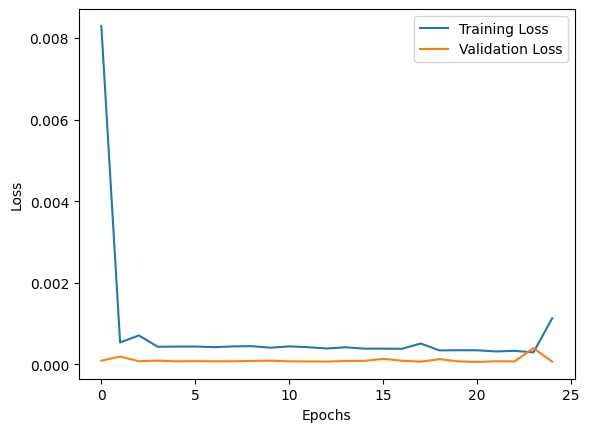

In [ ]:
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the line graph above, it can be seen that for both training and validation set, the base architecture did a good job in minimizing the loss that it is almost 0.

### D. Sequential Self-Attention Architecture

The sequential self-attention mechanism is a deep learning mechanism that enables a model to focus on different parts of an input sequence by giving each part a weight to determine its importance and dependencies with other parts. The self-attention mechanism works as follows:
1. The input sequence is represented as a matrix of embeddings, where each row corresponds to a different element in the sequence.
2. Each of the encoder input embeddings by each of the three weight matrices to produce queries (q), keys (k), and values (v).
3. Attention Scores: The attention scores are calculated as a function of the similarity between the queries and keys.
4. Query vector from the current input is multiplied by the key vectors from other inputs, then multiplying the score by the square root of the dimensions of the key vector to get the self-attention scores.
6. All of the self-attention scores will be subjected to the softmax function.
7. The value vector is multiplied by the determined vector from the previous step.
8. Lastly, the weighted value vectors obtained in the stage before are added to provide the self-attention output.

Sources:
1. Pardeshi, K., Gill, S. S., & Abdelmoniem, A. M. (2023). *Stock Market Price Prediction: A Hybrid LSTM and Sequential Self-Attention based Approach*.; https://arxiv.org/abs/2308.04419
2. Kharlova, E. (2021). *Time Series Forecasting using Sequence Models with Attention* [Master's thesis, University of Alberta]. ERA: Education and Research Archive.; https://era.library.ualberta.ca/items/ff7ef4e8-79e5-405d-8ed7-bb3d3fcc9d97/view/44bc7254-f2fc-4432-a260-896ce451746e/Kharlova_Elizaveta_202105_MSc.pdf

#### Build the model
For implementing the Sequential Self-Attention mechanism to the model we use the exact same architecture as the base architecture, but we'll be adding a Sequential Self-Attention layer as the second hidden layer using:
```
model.add(SeqSelfAttention())
```
that can be imported from the `keras-self-attention` library.

In [ ]:
model_attention = Sequential()
model_attention.add(LSTM(50, input_shape = (trainX.shape[1], trainX.shape[2]), return_sequences = True))
model_attention.add(SeqSelfAttention(attention_activation='linear'))
model_attention.add(LSTM(50, activation = 'linear'))
model_attention.add(Dense(1))

model_attention.compile(loss = 'mean_squared_error', optimizer = 'adam')
model_attention.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 50)             10400     
                                                                 
 seq_self_attention (SeqSel  (None, 5, 50)             3265      
 fAttention)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 33916 (132.48 KB)
Trainable params: 33916 (132.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train the model
After building the base model, we can train the model iteratively by using the training set and validation set to validate the model's performance. I'll be using epochs of 25 and batch size of 32.

In [ ]:
history_attention = model_attention.fit(trainX, trainY, epochs = 25, batch_size = 32, validation_data = (valX, valY))

Epoch 1/25
96/96 [==============================] - 6s 22ms/step - loss: 0.0110 - val_loss: 3.5005e-04
Epoch 2/25
96/96 [==============================] - 2s 26ms/step - loss: 7.0893e-04 - val_loss: 1.0818e-04
Epoch 3/25
96/96 [==============================] - 2s 23ms/step - loss: 4.6911e-04 - val_loss: 8.7944e-05
Epoch 4/25
96/96 [==============================] - 1s 13ms/step - loss: 4.6328e-04 - val_loss: 1.1871e-04
Epoch 5/25
96/96 [==============================] - 1s 13ms/step - loss: 4.5082e-04 - val_loss: 1.0348e-04
Epoch 6/25
96/96 [==============================] - 1s 13ms/step - loss: 4.5919e-04 - val_loss: 1.2673e-04
Epoch 7/25
96/96 [==============================] - 2s 18ms/step - loss: 4.4923e-04 - val_loss: 8.2622e-04
Epoch 8/25
96/96 [==============================] - 1s 13ms/step - loss: 0.0010 - val_loss: 1.8605e-04
Epoch 9/25
96/96 [==============================] - 1s 13ms/step - loss: 5.0915e-04 - val_loss: 1.1076e-04
Epoch 10/25
96/96 [==========================

#### Visualize the model loss
To better view the model performance, we can create a line graph of both training and validation loss in each epoch.

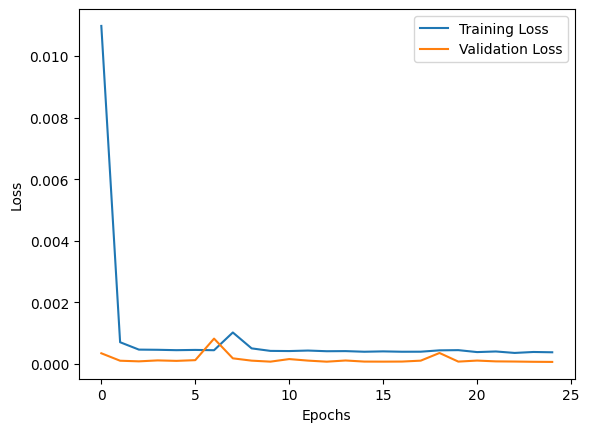

In [ ]:
plt.plot(history_attention.history['loss'], label = "Training Loss")
plt.plot(history_attention.history['val_loss'], label = "Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the line graph above, it can be seen that for both training and validation set, the modified Sequential Self-Attention architecture did a good job in minimizing the loss that it is almost 0.

### E. Architectures Evaluation

#### Predict the testing data
To do evaluation on both model, we must first conduct prediction for each model using the testing set. To do so, we can use:
```
[model name].predict([testing set])
```

In [ ]:
base_test_predict = base_model.predict(testX)
attention_test_predict = model_attention.predict(testX)

12/12 [==============================] - 2s 6ms/step


#### Inverse transformation of the predictions
After predicting the testing data, we have to inverse the transformation on the predictions and actual values back to their original scale before the preprocessing phase.

In [ ]:
base_predict = scaler.inverse_transform(base_test_predict)
attention_predict = scaler.inverse_transform(attention_test_predict)

In [ ]:
testY = scaler.inverse_transform(testY)

#### Calculate evaluation metrics of both architectures
I used 3 different evaluation metrics, which are:
1. Mean Absolute Error is an appropriate measure for evaluating the ability of a forecasting model to specify the median of the future values of a series. Since it is absolute, it ignores the positivity or negativity of the error and all indvidual errors are equally weighted.
```
mean_absolute_error([actual values], [prediction values])
```
2. Mean Squared Error is suitable for measuring the ability of a model to specify its mean. The squares of each error are added together and then averaged to ensure that all errors are equal in weight and that the direction of the error is irrelevant.
```
sqrt(mean_squared_error([actual values], [prediction values]))
```
3. R-Squared also known as the coefficient of determination which expresses the amount of variance in the dependent variable explained by a model. It measures the relationship between predicted and true data on a scale of 0–1. Higher R^2 values for similar datasets represent smaller differences between the predicted data and the true data.
```
r2_squared([actual values], [prediction values])
```

Sources:
1. Mitra, A., et. al. (2022). A Comparative Study of Demand Forecasting Models for a Multi-Channel Retail Company: A Novel Hybrid Machine Learning Approach. *Operations Research Forum, 3*(58).; https://link.springer.com/article/10.1007/s43069-022-00166-4
2. Spiliotis, E., Petropoulos, F., & Assimakopoulos, V. (2023). On the Disagreement of Forecasting Model Selection Criteria. *Forcasting 2023, 5*(2), 487-498.; https://www.mdpi.com/2571-9394/5/2/27

In [ ]:
base_mae = mean_absolute_error(testY, base_predict)
base_mse = mean_squared_error(testY, base_predict)
base_r2 = r2_score(testY, base_predict)

print("Base Architecure Metrics:")
print("MSE: ", base_mse)
print("MAE: ", base_mae)
print("R2: ", base_r2)

Base Architecure Metrics:
MSE:  7311.455824964833
MAE:  48.48826255090041
R2:  0.9731385292131443


In [ ]:
attention_mae = mean_absolute_error(testY, attention_predict)
attention_mse = mean_squared_error(testY, attention_predict)
attention_r2 = r2_score(testY, attention_predict)

print("Sequential Self-Attention Architecure Metrics:")
print("MSE: ", attention_mse)
print("MAE: ", attention_mae)
print("R2: ", attention_r2)

Sequential Self-Attention Architecure Metrics:
MSE:  8779.235865762366
MAE:  51.936329889676934
R2:  0.9677460695400938


Comparison:
- Base MSE: 7311.45 and Sequential Self-Attention MSE: 8779.24 ⟶ the base architecture has lower MSE value, meaning that the base architecture has a better performance since the lower the MSE, the closer is prediction to actual.
- Base MAE: 48.49 and Sequential Self-Attention MAE: 51.94 ⟶ the base architecture gives a lower MAE value, meaning that the base architecture has a better performance since the lower the MAE, the closer is prediction to actual.
- Base R^2: 0.973 and Sequential Self-Attention R^2: 0.968 ⟶ the base architecture is slightly better output where 97.3% closing stock price can be explained by the base model, whereas the modified model can only explain 96.8%.

<br>

Conclusion:
Based on the 3 metrics above, it can be concluded that the base architecture has a better performance.

### F. Base Prediction vs. Self Attention Prediction vs. Actual Values

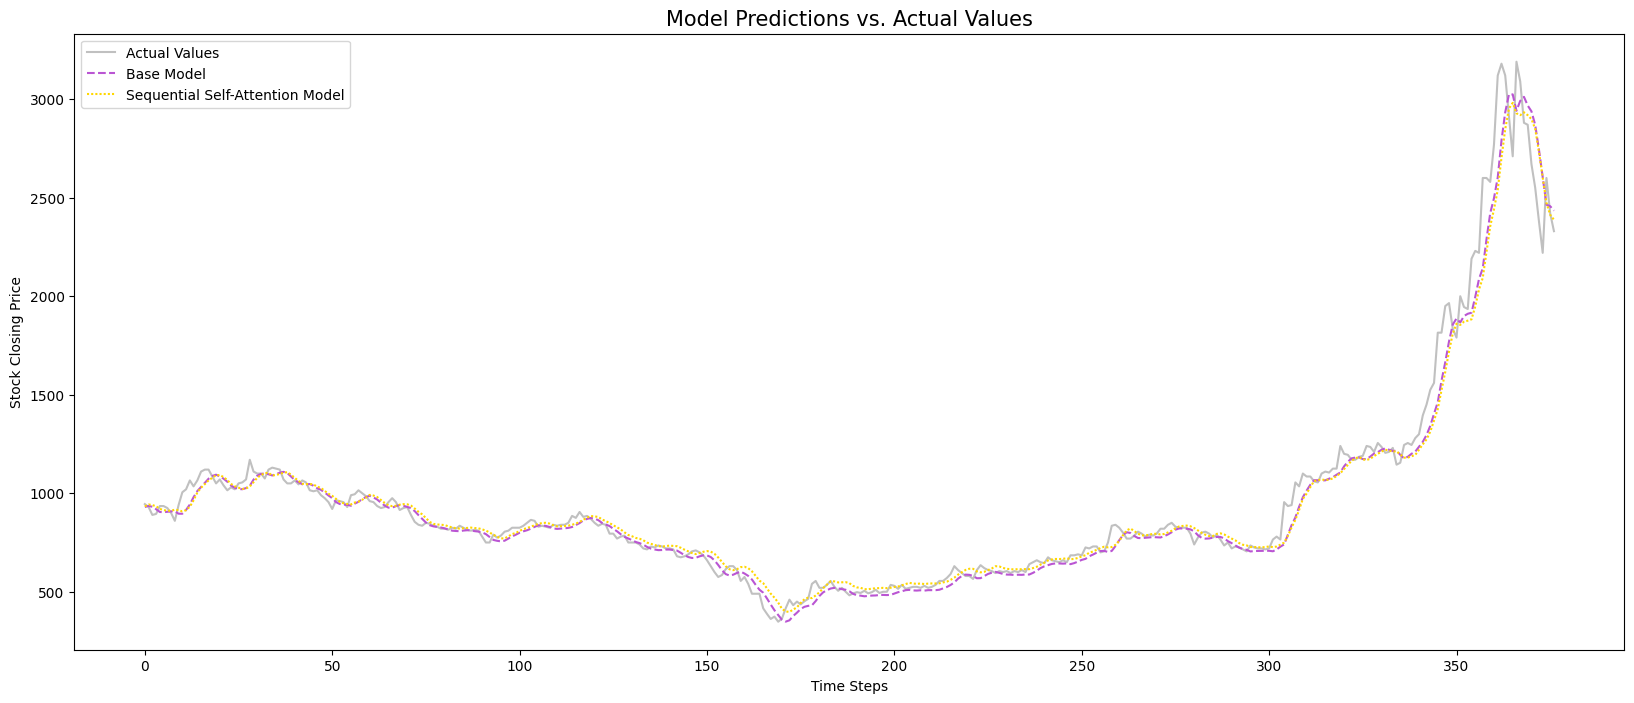

In [ ]:
base_predict_flat = base_predict.flatten()
attention_predict_flat = attention_predict.flatten()

plt.figure(figsize = (20, 8))

plt.plot(testY, label = "Actual Values", linestyle = 'solid', color = 'silver')
plt.plot(base_predict_flat, label = "Base Model", linestyle = 'dashed', color = 'mediumorchid')
plt.plot(attention_predict_flat, label = "Sequential Self-Attention Model", linestyle = (0, (1, 1)), color = 'gold')

plt.title("Model Predictions vs. Actual Values", size = 15)
plt.xlabel("Time Steps")
plt.ylabel("Stock Closing Price")
plt.legend()

plt.show()

Based on the line graph above, it can be seen that both model actual did a really great job on predicting the stock's closing price since both line never did stray far away from the actual line.